In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import normalize


import os
import pathlib
import sys
import matplotlib.pyplot as plt
from scipy import linalg


sys.path.append(os.path.join(pathlib.Path(os.getcwd()).parent))
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

from utils.bq_conn import bq_conn_file
# %%
bq_client = bq_conn_file(project_id="dsa-miad-365616")

In [2]:
pd.options.display.max_columns = None

query = '''
SELECT
    *
FROM `Proyecto.DatosSecopI`
ORDER BY anno_cargue_secop DESC
'''
bq_client = bq_conn_file(project_id="dsa-miad-365616")
secop_I = bq_client.execute_query(query=query)
#print(f"El número de filas del dataset: {secop_I.shape[0]}\nEl número de columnas del dataset: {secop_I.shape[1]}")
secop_I.head(5)
secop_I.columns




Index(['uid', 'anno_cargue_secop', 'id_modalidad', 'modalidad_de_contratacion',
       'estado_del_proceso', 'id_objeto_a_contratar',
       'detalle_del_objeto_a_contratar', 'tipo_de_contrato',
       'municipio_de_obtencion', 'municipios_ejecucion_',
       'departamento_ejecucion', 'numero_de_proceso', 'numero_de_contrato',
       'cuantia_proceso', 'id_grupo', 'nombre_grupo', 'id_familia',
       'nombre_familia', 'id_clase', 'nombre_clase', 'id_adjudicacion',
       'tipo_identifi_del_contratista', 'identificacion_del_contratista',
       'nom_razon_social_contratista', 'tipo_doc_representante_legal',
       'identific_representante_legal', 'plazo_de_ejec_del_contrato_',
       'dias_ejec_final_contrato', 'rango_de_ejec_del_contrato', 'prorrogado',
       'tiempo_adiciones_en_dias', 'cuantia_contrato', 'con_adicion_pptal',
       'valor_total_de_adiciones', 'valor_contrato_con_adiciones', 'moneda',
       'objeto_del_contrato_a_la', 'ruta_proceso_en_secop_i'],
      dtype='object'

In [54]:
secopI_filter = secop_I[
    [  'tipo_de_contrato', 'departamento_ejecucion', 'id_grupo',"cuantia_proceso",'id_objeto_a_contratar',
     'dias_ejec_final_contrato', 'valor_total_de_adiciones']] #'tiempo_adiciones_en_dias',

secopI_filter
secopI_filter.columns
base = secopI_filter
n = base.isna() == True
base = base.fillna(0)
base.info()
print(base)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26553 entries, 0 to 26552
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   tipo_de_contrato          26553 non-null  object
 1   departamento_ejecucion    26553 non-null  object
 2   id_grupo                  26553 non-null  object
 3   cuantia_proceso           26553 non-null  Int64 
 4   id_objeto_a_contratar     26553 non-null  Int64 
 5   dias_ejec_final_contrato  26553 non-null  Int64 
 6   valor_total_de_adiciones  26553 non-null  Int64 
dtypes: Int64(4), object(3)
memory usage: 1.5+ MB
                    tipo_de_contrato departamento_ejecucion id_grupo   
0                         suministro           cundinamarca        E  \
1            prestacion de servicios                 bogota        E   
2            prestacion de servicios                 bogota        E   
3            prestacion de servicios                 bogota        F

In [57]:
# Codificación de las variables categoricas
base['tipo_de_contrato'] = pd.factorize(base.tipo_de_contrato)[0]
base['departamento_ejecucion'] = pd.factorize(base.departamento_ejecucion)[0]
#base['detalle_del_objeto_a_contratar'] = pd.factorize(base.detalle_del_objeto_a_contratar)[0]
base['id_grupo'] = pd.factorize(base.id_grupo)[0]

In [58]:
df = base
df.columns

Index(['tipo_de_contrato', 'departamento_ejecucion', 'id_grupo',
       'cuantia_proceso', 'id_objeto_a_contratar', 'dias_ejec_final_contrato',
       'valor_total_de_adiciones'],
      dtype='object')

<Axes: >

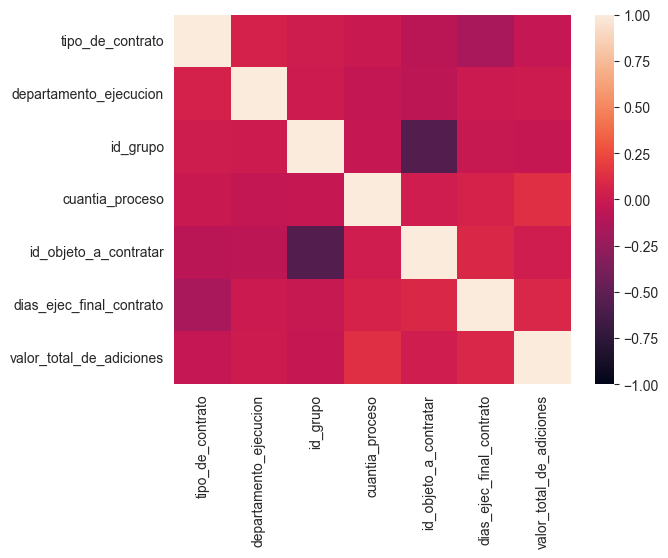

In [59]:
import seaborn as sns
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=False)


In [60]:
train_dataset = df.sample(frac=0.8,random_state=0)
test_dataset = df.drop(train_dataset.index)


train_X = train_dataset.drop(['valor_total_de_adiciones'], axis=1)
test_X = test_dataset.drop(['valor_total_de_adiciones'], axis=1)

In [61]:
train_stats = train_X.describe()
train_stats = train_stats.transpose()
train_stats


,count,mean,std,min,25%,50%,75%,max
tipo_de_contrato,21242.0,2.136098,2.327779,0.0,0.0,1.0,5.0,9.0
departamento_ejecucion,21242.0,8.671924,6.699319,0.0,3.0,8.0,12.0,30.0
id_grupo,21242.0,1.139488,1.814365,0.0,0.0,0.0,1.0,6.0
cuantia_proceso,21242.0,19836893.112607,178561205.183926,0.0,1500000.0,4522639.0,16000000.0,22980096902.0
id_objeto_a_contratar,21242.0,47790603.521326,19854229.145802,10000000.0,44000000.0,50000000.0,53000000.0,95000000.0
dias_ejec_final_contrato,21242.0,80.745645,144.756015,0.0,15.0,30.0,100.0,7500.0


In [62]:
train_labels = train_dataset.pop('valor_total_de_adiciones')
test_labels = test_dataset.pop('valor_total_de_adiciones')

In [63]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [64]:
[len(train_dataset.keys())]

[6]

In [65]:
def build_model ():
  model = keras.Sequential([
    layers.Dense(6, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(3, activation='relu'),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [66]:
model = build_model()

In [67]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 6)                 42        
                                                                 
 dense_21 (Dense)            (None, 3)                 21        
                                                                 
 dense_22 (Dense)            (None, 1)                 4         
                                                                 
Total params: 67 (268.00 Byte)
Trainable params: 67 (268.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [68]:
train_data = np.asarray(normed_train_data).astype(np.float32)
test_data = np.asarray(normed_test_data).astype(np.float32)


In [69]:
example_batch = train_data[:]
example_result = model.predict(example_batch)
example_result

664/664 [==============================] - 0s 386us/step


array([[ 0.4834007 ],
       [ 0.        ],
       [ 0.        ],
       ...,
       [ 0.18540102],
       [ 0.2932168 ],
       [-0.01180213]], dtype=float32)

In [70]:
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 200

from keras import backend as K
train_data = K.cast_to_floatx(train_data)
train_labels = K.cast_to_floatx(train_labels)

history = model.fit(
  train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................

In [71]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
print(hist)

             loss           mae           mse      val_loss      val_mae   
0    3.970694e+13  7.060653e+05  3.970694e+13  2.710808e+14  1139866.750  \
1    3.970694e+13  7.060665e+05  3.970694e+13  2.710808e+14  1139868.750   
2    3.970693e+13  7.060704e+05  3.970693e+13  2.710807e+14  1139873.250   
3    3.970693e+13  7.060774e+05  3.970693e+13  2.710807e+14  1139881.000   
4    3.970688e+13  7.060875e+05  3.970688e+13  2.710806e+14  1139893.375   
..            ...           ...           ...           ...          ...   
195  3.859013e+13  1.045021e+06  3.859013e+13  2.683548e+14  1464233.875   
196  3.858520e+13  1.046068e+06  3.858520e+13  2.683383e+14  1465253.000   
197  3.858016e+13  1.047348e+06  3.858016e+13  2.683241e+14  1465962.500   
198  3.857620e+13  1.048572e+06  3.857620e+13  2.683103e+14  1466522.625   
199  3.857095e+13  1.049168e+06  3.857095e+13  2.682944e+14  1467337.375   

          val_mse  epoch  
0    2.710808e+14      0  
1    2.710808e+14      1  
2    2

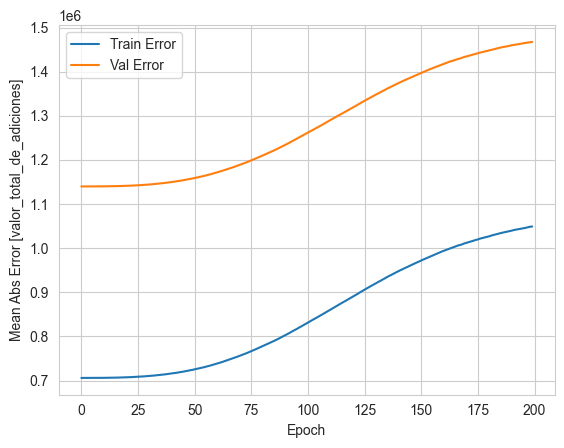

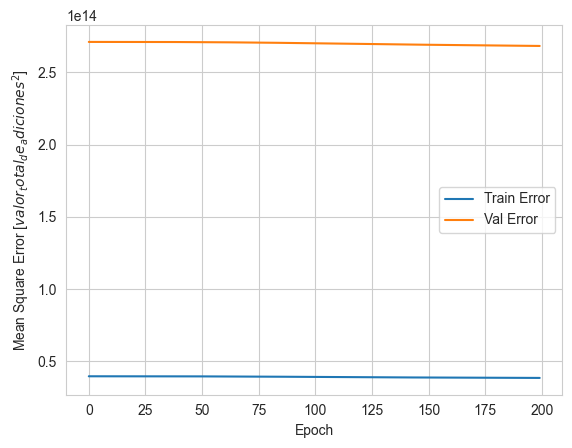

In [72]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [valor_total_de_adiciones]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$valor_total_de_adiciones^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.legend()
  plt.show()


plot_history(history)

In [73]:
model_imp = build_model()

In [74]:
test_data = np.asarray(normed_test_data).astype(np.float32)
example_result = model_imp.predict(np.array(test_data[:]))
resultados = pd.DataFrame(example_result)
resultados.columns = ['resultados']
resultados

166/166 [==============================] - 0s 716us/step


,resultados
0,0.000000
1,0.009447
2,0.012810
3,0.013283
4,0.013283
...,...
5306,0.001604
5307,0.036534
5308,-0.008942
5309,-0.113415


In [75]:
test_data = np.asarray(normed_test_data).astype(np.float32)

In [76]:
test_labels = pd.DataFrame(test_labels)
compare = pd.concat([resultados, test_labels], axis=1)
compare = compare.fillna(0)

In [77]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse_t = mean_squared_error(compare['resultados'], compare['valor_total_de_adiciones'])
mae_t = mean_absolute_error(compare['resultados'], compare['valor_total_de_adiciones'])
print("El MSE entre las columnas 'Modelo' y 'Dato' es:", mse_t)
print("El MAE entre las columnas 'Modelo' y 'Dato' es:", mae_t)


El MSE entre las columnas 'Modelo' y 'Dato' es: 29993952696120.254
El MAE entre las columnas 'Modelo' y 'Dato' es: 398013.357967523


In [53]:
weights = model.get_weights()[0]
biases = model.get_weights()[1]

# Imprimir los coeficientes
print("Coeficientes (m):")
for i, w in enumerate(weights):
    print(f"m{i+1}: {w[0]}")

print("")

# Imprimir el sesgo (intercepto) (B)
print("Sesgo (B):")
print(biases[0])

Coeficientes (m):
m1: -5.521910190582275
m2: -4.73265266418457
m3: -3.624376058578491
m4: -1.7713463306427002
m5: -7.766342639923096
m6: 2.1537187099456787
m7: 1.6838548183441162
m8: 12.38211727142334

Sesgo (B):
9.865838
